In [1]:
from jax_circuits import *
from topology import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
import math

# Learning random unitaries

In [21]:
num_qubits = 3
depth = theoretical_lower_bound(num_qubits)

anz = Ansatz(num_qubits, 'cz', placements=fill_layers(sequ_layer(num_qubits), depth))
anz.circuit().draw(output='mpl')
u_target = unitary_group.rvs(2**num_qubits, random_state=1)

In [22]:
%%time
_, loss_history = anz.learn(u_target)

CPU times: user 8 s, sys: 106 ms, total: 8.11 s
Wall time: 7.51 s


In [23]:
%%time
_, loss_history_aba = anz.learn(u_target, method='aba')

CPU times: user 30.3 s, sys: 224 ms, total: 30.5 s
Wall time: 27.9 s


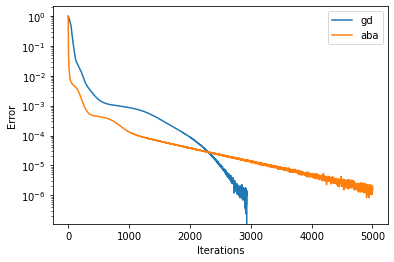

In [24]:
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.plot(loss_history, label='gd')
plt.plot(loss_history_aba, label='aba')
plt.legend()
plt.yscale('log')

## Restricted topology

In [5]:
num_qubits = 4
depth = theoretical_lower_bound(num_qubits)

anz_connected = Ansatz(num_qubits, 'cz', placements=fill_layers(sequ_layer(num_qubits), depth))
anz_chain = Ansatz(num_qubits, 'cz', placements=fill_layers(chain_layer(num_qubits), depth))

u_target = unitary_group.rvs(2**num_qubits, random_state=0)

_, loss_history_connected = anz_connected.learn(u_target)
_, loss_history_chain = anz_chain.learn(u_target)

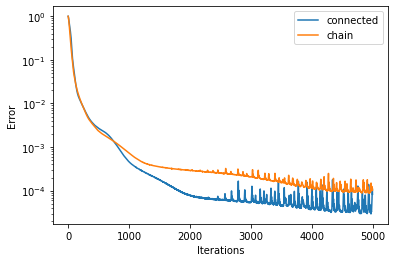

In [6]:
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.plot(loss_history_connected, label='connected')
plt.plot(loss_history_chain, label='chain')
plt.legend()
plt.yscale('log')

## CNOT count as expressivity of a circuit

In [10]:
%%time

num_qubits = 3

u_target = unitary_group.rvs(2**num_qubits, random_state=42)

best_losses = []
for d in range(theoretical_lower_bound(num_qubits)+1):
    anz = Ansatz(num_qubits, 'cz', placements=fill_layers(sequ_layer(num_qubits), d))
    _, loss_history = anz.learn(u_target, target_disc=1e-4)
    best_losses.append(min(loss_history))

CPU times: user 2min 1s, sys: 3.39 s, total: 2min 5s
Wall time: 1min 53s


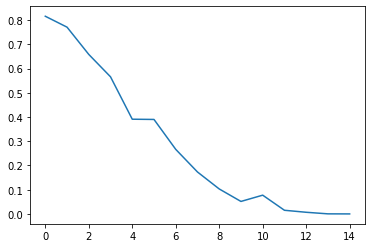

In [15]:
plt.plot(best_losses)

## State preparation

In [61]:
def state_tlb(n):
    return math.ceil((2**(n+1)-2*n-1)/4)

def state_learn(u, s_target, num_angles, **kwargs):
    all_zero_state = jnp.zeros(s_target.shape).at[0].set(1)
    def cost_func(angles):
        s_u = u(angles) @ all_zero_state
        return 1-jnp.abs((s_u.conj()*s_target).sum())
    
    return gradient_descent_learn(cost_func, num_angles, **kwargs)

In [62]:
%%time

num_qubits = 5
depth =  state_tlb(num_qubits)

anz = Ansatz(num_qubits, 'cz', placements=fill_layers(sequ_layer(num_qubits), depth))

state_target = unitary_group.rvs(2**num_qubits, random_state=42)[0]
angles_history, loss_history = state_learn(anz.unitary, state_target, anz.num_angles)

CPU times: user 29.9 s, sys: 345 ms, total: 30.3 s
Wall time: 28.8 s


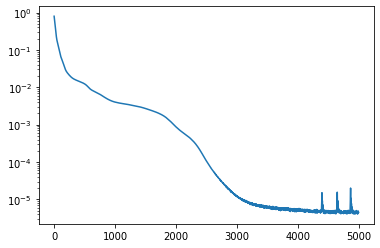

In [63]:
plt.plot(loss_history)
plt.yscale('log')

Let's make a sweep

In [84]:
%%time

num_qubits = 5
depth = state_tlb(num_qubits)

target_state = unitary_group.rvs(2**num_qubits, random_state=7)[0]


best_losses_conn = []
best_losses_chain = []

for d in range(depth+1):
    anz_conn = Ansatz(n_qubits, 'cz', placements=fill_layers(sequ_layer(n_qubits), d))
    anz_chain = Ansatz(n_qubits, 'cz', placements=fill_layers(chain_layer(n_qubits), d))

    _, loss_history_conn = state_learn(anz_conn.unitary, target_state, anz_conn.num_angles)
    _, loss_history_chain = state_learn(anz_chain.unitary, target_state, anz_chain.num_angles)
    
    best_losses_conn.append(loss_history_conn[-1])
    best_losses_chain.append(loss_history_chain[-1])

CPU times: user 5min 56s, sys: 4.75 s, total: 6min 1s
Wall time: 5min 16s


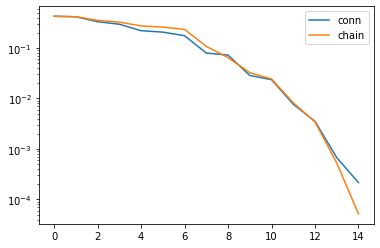

In [85]:
plt.plot(best_losses_conn, label='conn')
plt.plot(best_losses_chain, label='chain')
plt.yscale('log')
plt.legend()

Compare learning of connected vs learning of chain on 6 qubits.

In [71]:
%%time

num_qubits = 6
depth =  state_tlb(num_qubits)
print(depth)

state_target = unitary_group.rvs(2**num_qubits, random_state=100)[0]

# Connected topology
anz = Ansatz(num_qubits, 'cz', placements=fill_layers(sequ_layer(num_qubits), depth))
angles_history_conn, loss_history_conn = state_learn(anz.unitary, 
                                                     state_target, 
                                                     anz.num_angles,
                                                     n_iterations=10000)                                              

# Chain topology
anz = Ansatz(num_qubits, 'cz', placements=fill_layers(chain_layer(num_qubits), depth))
angles_history_chain, loss_history_chain = state_learn(anz.unitary, 
                                                       state_target, 
                                                       anz.num_angles,
                                                       n_iterations=10000)                                              

29
CPU times: user 2min 34s, sys: 1.73 s, total: 2min 36s
Wall time: 2min 25s


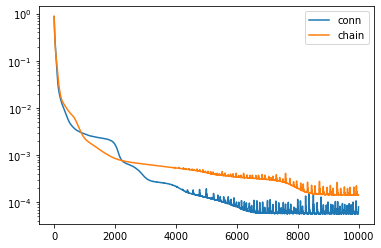

In [72]:
plt.plot(loss_history_conn, label='conn')
plt.plot(loss_history_chain, label='chain')
plt.yscale('log')
plt.legend()

Push sparse connectivity further.

In [77]:
%%time

num_qubits = 8
depth =  state_tlb(num_qubits)

state_target = unitary_group.rvs(2**num_qubits, random_state=15)[0]

# Chain topology
anz = Ansatz(num_qubits, 'cz', placements=fill_layers(chain_layer(num_qubits), depth))
angles_history, loss_history = state_learn(anz.unitary, 
                                           state_target, 
                                           anz.num_angles,
                                           target_disc=1e-4,
                                           n_iterations=10000)                                              

CPU times: user 15min, sys: 2min 18s, total: 17min 19s
Wall time: 9min 31s


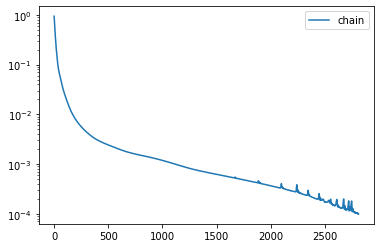

In [78]:
plt.plot(loss_history, label='chain')
plt.yscale('log')
plt.legend()